## CNN
#### We will be applying basic CNN arch. to the fashion-mnist problem

In [19]:
import torch
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn as nn
from sympy.physics.units import current
from torch.nn.functional import dropout
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from PyTorch import accuracy

In [20]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv("/home/ml02/Downloads/PyTorch/archive/fashion-mnist_train.csv")
X = df.iloc[:,1:].values
y = df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train/255.0
X_test = X_test/255.0

In [21]:
# In our ANN model this CustomDataset gives only one row i.e. 1D data
# but in CNN based architecture we need to send the data in 2D format
# and with batch_size
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # we are basically converting the 784 one-dimensional to 28*28 two-dimensional
        # also we have to specify the batch size also i.e. how many rows we are sending simultaneously
        # '-1' is the placeholder for the batch_size
        # '1' is the channel here as the images are all greyscale
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28) # 28*28 = 784
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, item):
        return self.features[item], self.labels[item]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

#### Building the CNN architecture

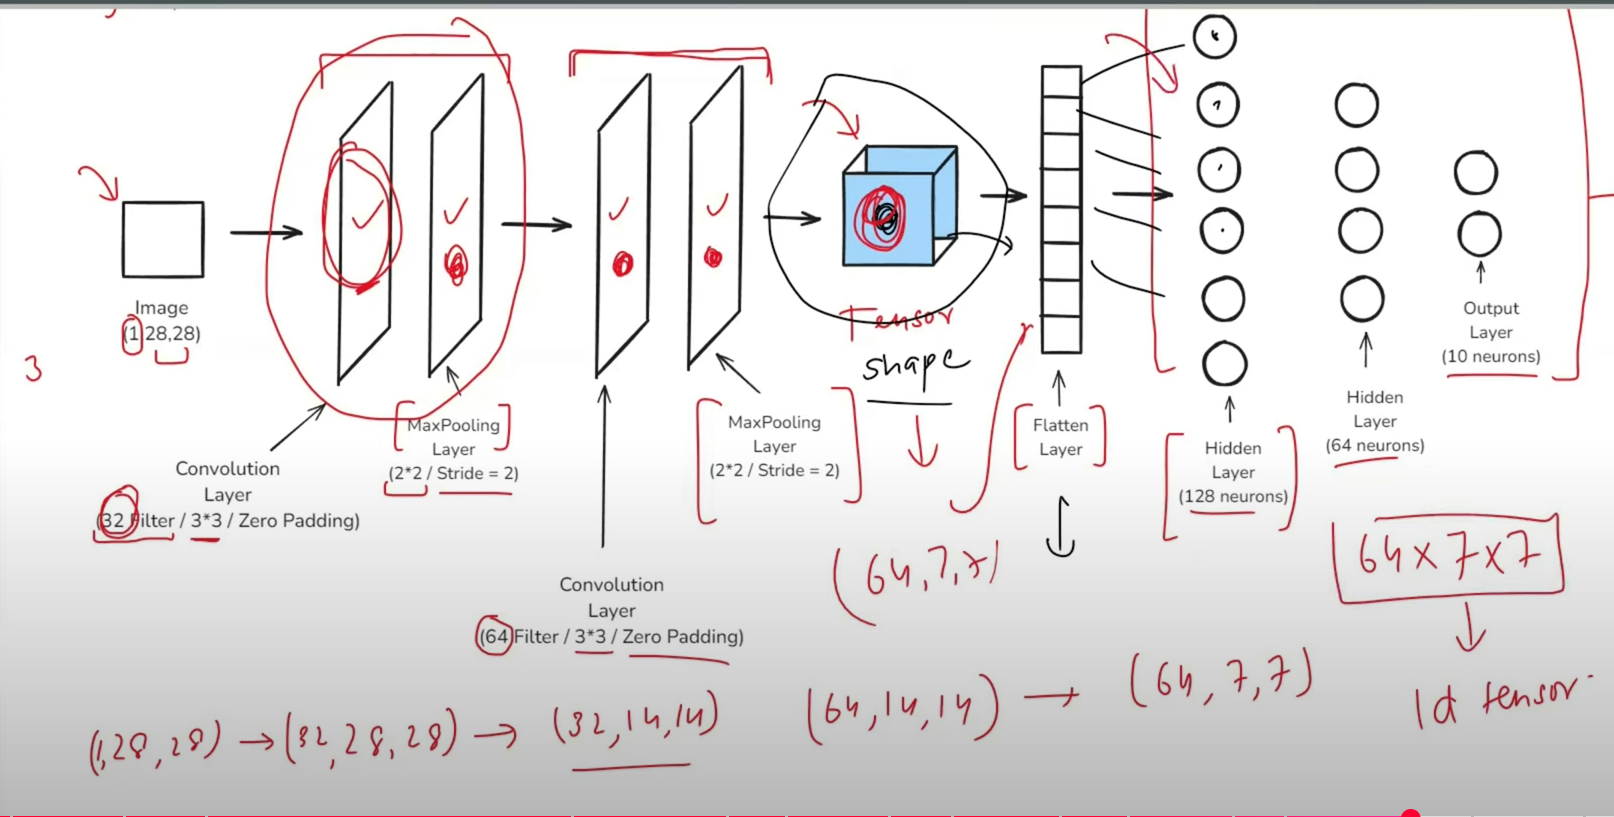

In [24]:
# The image will be propagating through two stages in forward propagation namely - 1) Feature Extraction & 2) Classification

class MyNN(nn.Module):
    def __init__(self, input_features): # input_features variable holds the number of channels here
        super().__init__()
        self.features = nn.Sequential(
            # Same padding will ensure that the shape of the image remains same after the conv. ops.
            # Image size is (1,28,28)
            nn.Conv2d(in_channels=input_features, out_channels=32, kernel_size=3, padding='same'),
            # now the shape of the tensor will be (32,28,28) as we are using 32 channels
            # but the image size will remain same because of 'same' padding
            nn.BatchNorm2d(32), # 32 as this convolution layer is using 32 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # As we are using pooling layer with kernel 2 the image size will get halved
            # So the shape of the tensor after the first pooling layer will be (32,14,14)

            # Repeating the 1st part again as we are using two sets of same convolution
            # The input channel for this conv. will be the output channel of the first convolution
            # This conv. layer will use 64 filters hence out_channels will be 64
            # Gets input tensor of shape (32,14,14)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),
            # now tensor of shape (64,14,14) after the 2nd conv because of out_channels=64 and 'same' padding
            nn.BatchNorm2d(64), # 64 as this convolution layer is using 64 filters
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Image size will get halved after the 2nd pooling layer making the tensor shape (64,7,7)
            # This tensor will get passed into the flatten layer
        )
        # Classifier stage will be consists of -
        # First Flatten layer which will take the output of the 2nd conv layer
        # and will convert the tensors to a 1D array i.e. 64*7*7
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # First Hidden Layer
            nn.Linear(64*7*7, 128),
            nn.BatchNorm1d(128), # Added BatchNorm1D as the tensor is 1D here with 128 channels/neurons
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # Second Hidden Layer
            nn.Linear(128, 64),
            nn.BatchNorm1d(64), # Added BatchNorm1D as the tensor is 1D here with 64 channels/neurons
            nn.ReLU(),
            nn.Dropout(p=0.4),

            # Output Layer
            nn.Linear(64, 10)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [25]:
lr = 0.01
epochs = 100

In [26]:
model = MyNN(1) # Here '1' Signifies number of input channels
# '1' input channel here because of rgb image
model.to(device)

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

In [9]:
# Training loop will remain same as in case of ANN example
model.train()
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()
    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch: {epoch+1}; Loss: {avg_loss}')

Epoch: 1; Loss: 0.723328710814317
Epoch: 2; Loss: 0.43755092298487824
Epoch: 3; Loss: 0.3746678422242403
Epoch: 4; Loss: 0.3403738093028466
Epoch: 5; Loss: 0.3143609090993802
Epoch: 6; Loss: 0.2887245650663972
Epoch: 7; Loss: 0.27390077827125786
Epoch: 8; Loss: 0.2537660354201992
Epoch: 9; Loss: 0.24600231101860603
Epoch: 10; Loss: 0.2334628770550092
Epoch: 11; Loss: 0.21960766249522568
Epoch: 12; Loss: 0.21350184819847345
Epoch: 13; Loss: 0.20393381823102633
Epoch: 14; Loss: 0.19049762781212728
Epoch: 15; Loss: 0.18649438966438175
Epoch: 16; Loss: 0.18132095521440109
Epoch: 17; Loss: 0.17406413212791086
Epoch: 18; Loss: 0.16774750575050712
Epoch: 19; Loss: 0.16006060135612885
Epoch: 20; Loss: 0.15486908892728388
Epoch: 21; Loss: 0.15028162829391659
Epoch: 22; Loss: 0.1461001368649304
Epoch: 23; Loss: 0.1387398793020596
Epoch: 24; Loss: 0.13394012331186483
Epoch: 25; Loss: 0.1302845387812704
Epoch: 26; Loss: 0.12255520036568245
Epoch: 27; Loss: 0.12588813972162705
Epoch: 28; Loss: 0.12

In [10]:
# Evaluate

model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU

In [11]:
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_features.shape[0]
        correct += (predicted == batch_labels).sum().item()
print(f"Evaluation Accuracy on Test Data: {correct/total}")

Evaluation Accuracy on Test Data: 0.9229166666666667


In [12]:
total, correct = 0, 0
with torch.no_grad():
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs, 1)
        total += batch_features.shape[0]
        correct += (predicted == batch_labels).sum().item()
print(f"Evaluation Accuracy on Train Data: {correct/total}")

Evaluation Accuracy on Train Data: 0.9997916666666666


# CNN With Optuna and Data Augmentation

In [1]:
import optuna
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pd.read_csv("/home/ml02/Downloads/PyTorch/archive/fashion-mnist_train.csv")
X = df.iloc[:,1:].values
y = df.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train/255.0
X_test = X_test/255.0

In [3]:
# We will use torchvision to build a transformation pipeline
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [4]:
## Can also use the albumentations library

# import albumentations as A
# from albumentations.pytorch import ToTensorV2
#
# # Train transform using Albumentations
# train_transform = A.Compose([
#     A.ToPILImage(),                 # Optional if input is a NumPy array
#     A.RandomRotate90(p=0.5),        # Random rotation by multiples of 90 degrees
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=10, p=0.5),
#     A.ToFloat(),
#     A.ToTensorV2(),                 # Converts HxWxC numpy array to CxHxW tensor
# ])
#
# test_transform = A.Compose([
#     A.ToPILImage(),
#     A.ToFloat(),
#     A.ToTensorV2()
# ])

In [5]:
# We will be implementing the transformation(image augmentation) in the dataset class itself

class CustomDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.transform = transform
        self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, item):
        feature, label = self.features[item], self.labels[item]

        ## If we were like to use albumentations library then the transformation code would be like below:
        # Albumentations expects H*W*C format; for grayscale, we add channel dim
        # feature = feature.squeeze(0).numpy()  # Shape: [28, 28]
        # feature = np.expand_dims(feature, axis=-1)  # Shape becomes: [28, 28, 1]

        """
        For RGB image in albumentations::
        # If grayscale (e.g., shape (28, 28)), expand to (28, 28, 1), then repeat to (28, 28, 3)
        if len(feature.shape) == 2 or feature.shape[-1] == 1:
            feature = np.expand_dims(feature, axis=-1)  # (28, 28, 1)
            feature = np.repeat(feature, 3, axis=-1)     # (28, 28, 3)
        """
        # The transformation logic will be applied in the getitem function
        if self.transform:
            feature = self.transform(feature.squeeze(0).numpy())

            """
            The feature is of shape(1,28,28)
            squeeze(0) removes the first dimension of size 1 resulting in shape(28,28)
            .numpy will convert the pytorch tensor to a numpy array
            This explicit type casting to numpy array is required as
            some transforms in torchvision.transforms expect Numpy arrays
            or PIL images as input (like transform.ToPILImage()...)
            after applying self.transform(..) the output is a transformed PyTorch tensor
            due to transform.ToTensor() at the end of the transform pipeline
            """

            ## If we were like to use albumentations library then the transformation code would be like below:
            # feature = self.transform(image=feature)['image']

        return feature, label

In [6]:
# Use augmentations in training data
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

In [7]:
class MyDynamicCNN(nn.Module):
    def __init__(self, input_channels, num_conv_layers, num_fc_layers, num_filters, kernel_size, image_size, fc_layer_size, dropout_rate):
        super().__init__()
        layers = []
        in_channels = input_channels
        current_filters = num_filters

        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels=in_channels, out_channels=current_filters, kernel_size=kernel_size, padding='same'))
            layers.append(nn.BatchNorm2d(current_filters))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = current_filters
            current_filters *= 2

        self.features = nn.Sequential(*layers)

        # Fully Connected Layers
        feature_size = image_size // (2 ** num_conv_layers)
        input_size = in_channels * feature_size * feature_size

        fc_layers = [nn.Flatten()]
        current_fc_layer_size = fc_layer_size
        for _ in range(num_fc_layers):
            fc_layers.append(nn.Linear(input_size, current_fc_layer_size))
            fc_layers.append(nn.BatchNorm1d(current_fc_layer_size))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(dropout_rate))
            input_size = current_fc_layer_size
            current_fc_layer_size //= 2
        fc_layers.append(nn.Linear(input_size, 10))

        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return  x

In [31]:
my_dynamic_model = MyDynamicCNN(
    input_channels=1,         # MNIST grayscale
    num_conv_layers=2,
    num_fc_layers=2,
    num_filters=32,           # First conv layer filters
    kernel_size=3,
    image_size=28,            # MNIST image size
    fc_layer_size=128,        # First FC layer size
    dropout_rate=0.4
)

In [27]:
# This is the architecture of the custom model
print(model)

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU

In [32]:
# This is the architecture of the dynamic model
print(my_dynamic_model)

MyDynamicCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (

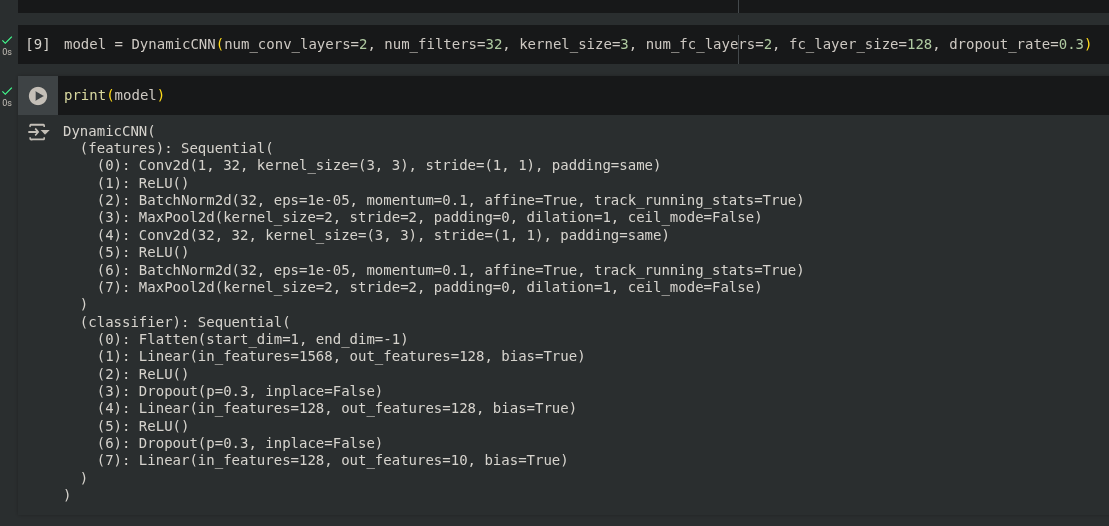
*This is the architecture of the model given in the video description which is different from our custom model*

In [10]:
def objective(trial):
    num_conv_layers = trial.suggest_int('num_conv_layers', 1, 3)
    num_fc_layers = trial.suggest_int('num_conv_layers', 2, 4)
    num_filters = trial.suggest_categorical('num_filters', [16,32,64,128])
    kernel_size = trial.suggest_categorical('kernel_size', [3,5])
    fc_layer_size = trial.suggest_categorical('fc_layer_size', [128, 256, 512])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5, step=0.1)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    batch_size = trial.suggest_categorical("batch_size", [16,32,64,128])
    epochs = trial.suggest_int("epochs", 10, 30, step=10)

    # Initiate the model
    model = MyDynamicCNN(1, num_conv_layers, num_fc_layers, num_filters, kernel_size, 28, fc_layer_size, dropout_rate).to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    if optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Loss fnc
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs,  batch_labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()
        accuracy = correct/total
    return  accuracy

In [11]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=6)

[I 2025-07-11 20:19:38,449] A new study created in memory with name: no-name-d7994c39-7bb6-409d-8aeb-8e427d6a125a
[I 2025-07-11 20:24:41,998] Trial 0 finished with value: 0.8865 and parameters: {'num_conv_layers': 1, 'num_filters': 16, 'kernel_size': 3, 'fc_layer_size': 128, 'dropout_rate': 0.4, 'weight_decay': 0.00016028608399507044, 'lr': 0.0007165200747182696, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 20}. Best is trial 0 with value: 0.8865.
[I 2025-07-11 20:36:05,033] Trial 1 finished with value: 0.38825 and parameters: {'num_conv_layers': 1, 'num_filters': 128, 'kernel_size': 5, 'fc_layer_size': 128, 'dropout_rate': 0.4, 'weight_decay': 0.0009893145044439474, 'lr': 0.05337612033559958, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 30}. Best is trial 0 with value: 0.8865.
[I 2025-07-11 20:39:00,880] Trial 2 finished with value: 0.843 and parameters: {'num_conv_layers': 1, 'num_filters': 64, 'kernel_size': 3, 'fc_layer_size': 256, 'dropout_rate': 0.30000000000000004,

In [10]:
# Print the best hyperparameters and accuracy
# print("Best Hyperparameters:", study.best_params)
# print("Best Accuracy:", study.best_value)

Best Hyperparameters: {'num_conv_layers': 2, 'num_filters': 64, 'kernel_size': 3, 'fc_layer_size': 512, 'dropout_rate': 0.4620641432338689, 'weight_decay': 0.009132529573250562, 'lr': 0.0037984291641415075, 'optimizer': 'SGD', 'batch_size': 16, 'epochs': 30}
Best Accuracy: 0.9141666666666667


In [12]:
print("Best Hyperparameters:", study.best_params)
print("Best Accuracy:", study.best_value)

Best Hyperparameters: {'num_conv_layers': 1, 'num_filters': 16, 'kernel_size': 3, 'fc_layer_size': 128, 'dropout_rate': 0.4, 'weight_decay': 0.00016028608399507044, 'lr': 0.0007165200747182696, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 20}
Best Accuracy: 0.8865
